## Understanding Test of Hypothesis using 2019 - Stack overflow survey dataset

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [0]:
# Reading the survey data and obtaining columns of interest
# Here we have used Survey rows for respondents of US and whose annual income listed in USD
df = pd.read_csv('survey_results_public.csv')
df = df.loc[(df['CurrencySymbol'] == 'USD') & (df['Country'] == 'United States')][['EdLevel', 'ConvertedComp']]
df.head()

,EdLevel,ConvertedComp
3,"Bachelor’s degree (BA, BS, B.Eng., etc.)",61000.0
12,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",90000.0
21,Some college/university study without earning ...,103000.0
22,"Bachelor’s degree (BA, BS, B.Eng., etc.)",69000.0
25,Some college/university study without earning ...,114000.0


## Let us say we want to find if there is a difference between education level of Bachelors / Masters on their Annual compensation

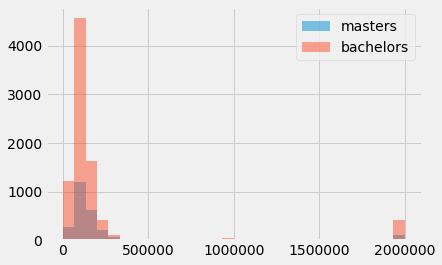

In [0]:
masters_col = "Master’s degree (MA, MS, M.Eng., MBA, etc.)"
bachelors_col = "Bachelor’s degree (BA, BS, B.Eng., etc.)"
levels = [masters_col, bachelors_col]

def plot_hist(df):
  masters_salary = df[df['EdLevel'] == masters_col]['ConvertedComp']
  bachelors_salary = df[df['EdLevel'] == bachelors_col]['ConvertedComp']
  plt.hist(masters_salary, bins=30, alpha=0.5,label='masters',)
  plt.hist(bachelors_salary, bins=30, alpha=0.5, label='bachelors')
  plt.legend(loc='upper right')
  plt.show()
  
plot_hist(df)

# Using the right statistic is of paramount importance 
We see that the salary range is skewed. Hence we can choose difference between the medians of the group to be more robust for skewed data.

In [0]:
## Computing the observed difference in median salaries between the groups
population = df.groupby('EdLevel').median()
observed_difference = population.loc[masters_col] - population.loc[bachelors_col]
observed_difference

ConvertedComp    15000.0
dtype: float64

We can use the Hypothesis testing here.

1) Null Hypothesis - There is no significant difference between the median salaries of developers who completed Bachelor's degree from that of whom completed Master's degree - So the difference between their median is 0

2) Alternate Hypothesis - The median salary of developers with Masters degree is greater than that of Bachelors's degree - which is 
median(Master_salaries) - median(Bachelor_salaries) > 0

In [0]:
# Let us find out the proportions of Bachelors to Masters degree in our data
df_base = df[df['EdLevel'].isin(levels)]
counts = df_base.groupby('EdLevel').count()
counts

,ConvertedComp
EdLevel,
"Bachelor’s degree (BA, BS, B.Eng., etc.)",8823
"Master’s degree (MA, MS, M.Eng., MBA, etc.)",2661


In [0]:
proportion = (counts/counts.sum()).values
proportion

array([[0.76828631],
       [0.23171369]])

In [0]:
## Let us drop the other education levels except Bachelors and Masters
df_base.head()

,EdLevel,ConvertedComp
3,"Bachelor’s degree (BA, BS, B.Eng., etc.)",61000.0
12,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",90000.0
22,"Bachelor’s degree (BA, BS, B.Eng., etc.)",69000.0
28,"Bachelor’s degree (BA, BS, B.Eng., etc.)",100000.0
34,"Bachelor’s degree (BA, BS, B.Eng., etc.)",80000.0


For conducting the test, we can use simulation to generate data by taking lot of samples using the bootstrap technique (Sampling with replacement)

In [0]:
## Test statistic computation
def compute_test_statistic(df):
  test_result = df.groupby('EdLevel').median()
  return (test_result.loc[masters_col] - test_result.loc[bachelors_col]).values

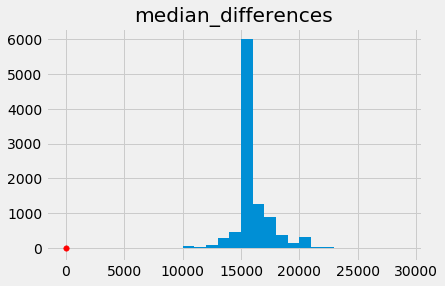

In [0]:
## Performing the experiment multiple iteration
iterations = 10000
differences = []

for i in range(iterations):
  resampled_data = df_base.sample(frac=1.0,replace=True)
  test_statistic = compute_test_statistic(resampled_data)
  differences.append(test_statistic)

pd.DataFrame(differences, columns=['median_differences']).hist(bins=np.arange(0,30000,1000));
plt.scatter(0,0,color='red', s=30); # Mark the null hypothesis assumption

#### Thus from the distribution of median differences between the two groups is clearly positive and ranging around 15000 USD as observed earlier from the population. Whereas we can see the red dot marked at 0 is completely outside this sampling distribution of difference in medians.

### Hence we can safely conclude that we can reject the Null Hypothesis

### Wait! What about the p-value!! ?

In [0]:
#Let us compute the p-value
np.average([True if 0 > value else False for value in differences])

0.0

This seems to be extreme case where we have absolutely not once in our 10000 experiment, we never had the test statistic to be <= 0.

### Another interesting question is what would have been the median difference to mark the p-value significance of atleast 5%

In [0]:
np.percentile(differences, 5)

14000.0

Can we conclude that whether the Education level results in higher annual income ?

## Unfortunately no. 
Why ??
Because there could be so many confounding factors we did not look at such as experience, age, gender, technology stack and so on.

## So how to determine the real cause of higher salary ?
## To determine that we need to do Randomized Controlled Experiment. More on that later!!